In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries:

In [2]:
# !pip install --upgrade tensorflow

In [3]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
import string
import tensorflow as tf

## Reading Data:

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/summer_course/train.csv', index_col='id')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
test_df = pd.read_csv('/content/drive/MyDrive/summer_course/test.csv', index_col='id')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [6]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


**Looking at count values of asian,atheist etc columns we see that there are a lot of Null values present, but this is OK as we are only supposed to use 'comment_text' column so dealing with these is not really necessary here.**

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                       

In [8]:
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

**No Null values for target and comment_text columns**

In [9]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804874, 44) (97320, 1)


## Exploratory Data Analysis:

### 1. Target Feature:

<ipython-input-10-e072d358cf93>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')


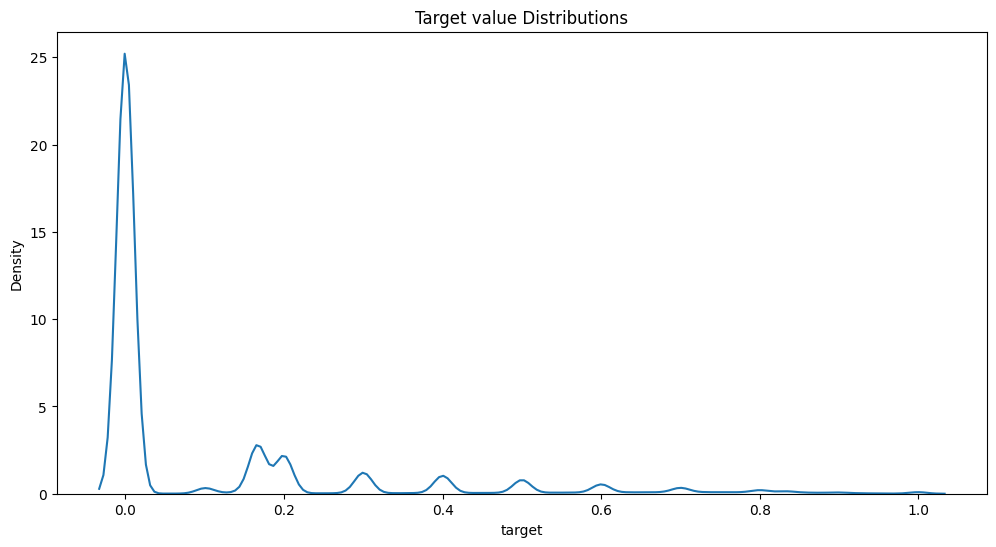

In [10]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

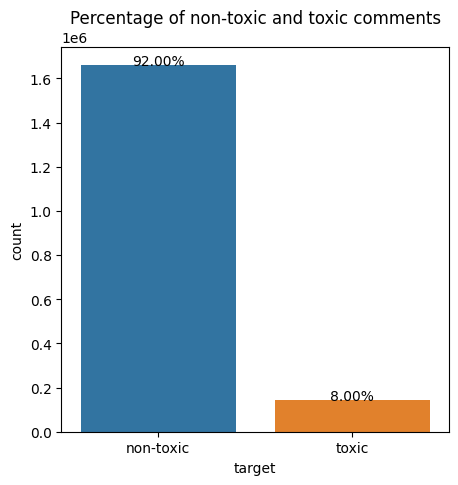

In [11]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

# Plot the number and percentage of toxic and non-toxic comments.
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

# Plot the count plot.
cntplot = sns.countplot(data=train_df, x=temp)
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')

plt.show()

**The dataset is imbalanced as 92% of the comments are non-toxic and only 8% are toxic**

### 2. Toxicity Subtype Features:
- severe_toxicity
- obscene
- threat
- insult
- identity_attack

In [12]:
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

<ipython-input-12-93d331503461>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
<ipython-input-12-93d331503461>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],kde=True,hist=False, bins=240, label=featu

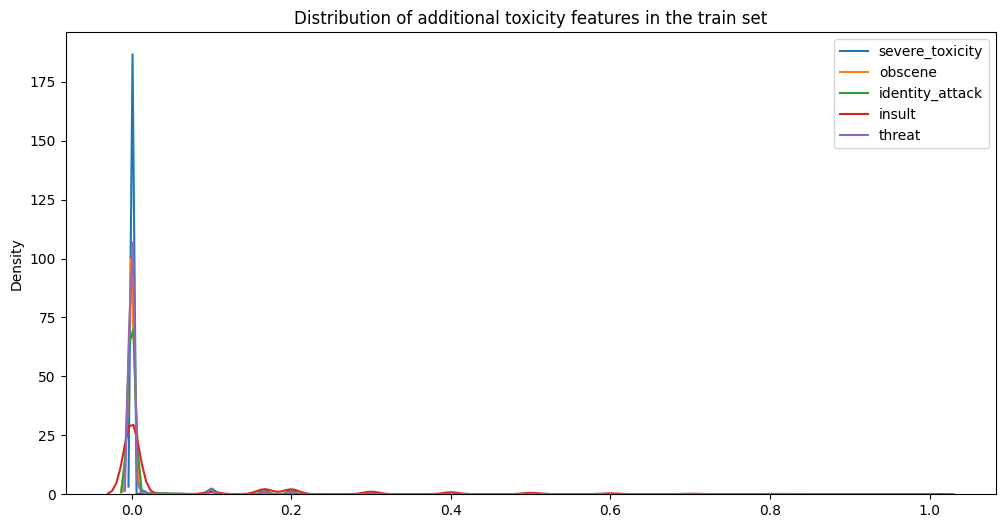

In [13]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

<ipython-input-12-93d331503461>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
<ipython-input-12-93d331503461>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],kde=True,hist=False, bins=240, label=featu

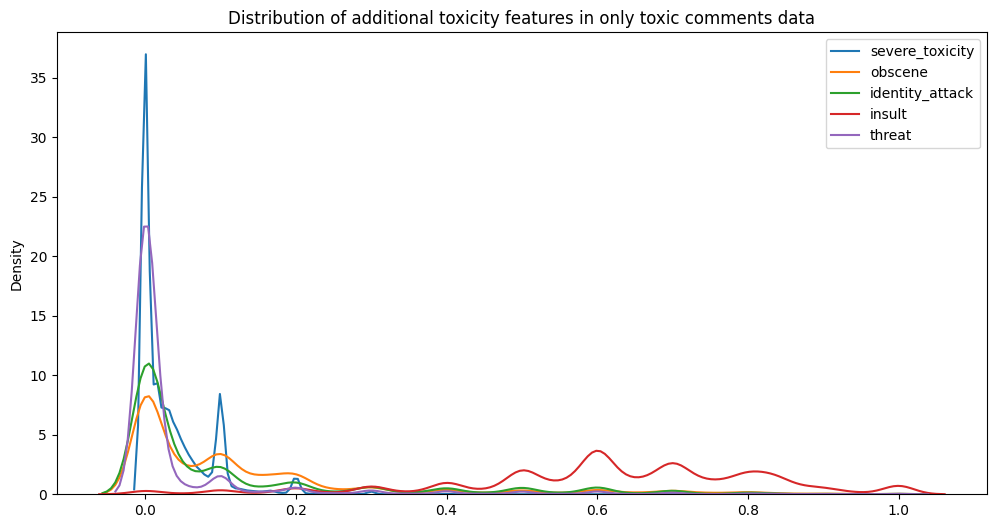

In [14]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

**We see that for toxic comments data, there are more insulting comments as compared to obscene comments**

In [15]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]

    maxarg = np.argmax(np.array(row)) # Get the max value index.

    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

In [16]:
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

<ipython-input-16-93d331503461>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
<ipython-input-16-93d331503461>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],kde=True,hist=False, bins=240, label=featu

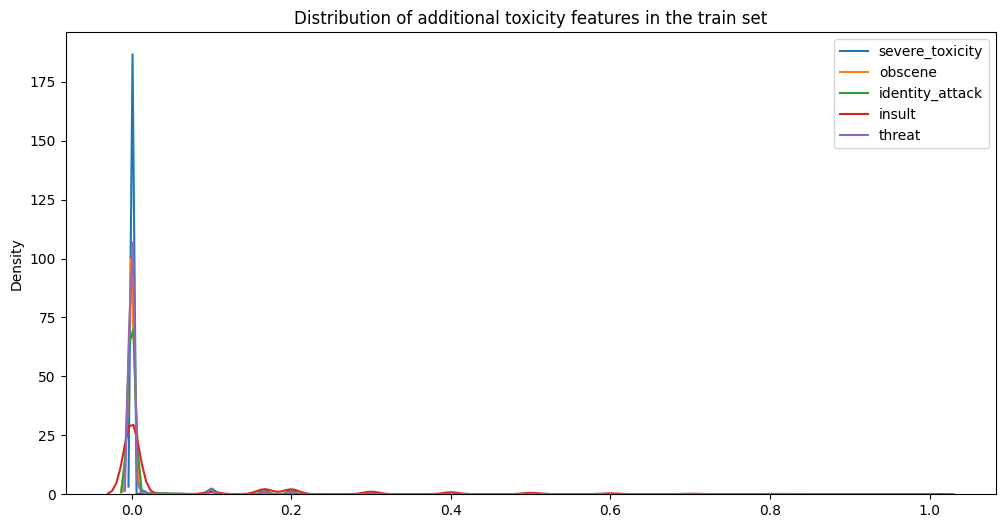

In [17]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

**In our train dataset only 8% of the data was toxic. Out of that 8%, 81% of the toxic comments made are insults, 8.37% are identity attacks, 7.20% are obscene, 3.35% are threats and a very small amount of toxic comments are severly toxic.**

### 3. Identity Attributes:

Sensitive topics:

- male
- female
- homosexual_gay_or_lesbian
- bisexual
- heterosexual
- christian
- jewish
- muslim
- black
- white
- asian
- latino

In [18]:
temp = train_df.dropna(axis = 0, how = 'any')

<ipython-input-16-93d331503461>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
<ipython-input-16-93d331503461>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],kde=True,hist=False, bins=240, label=featu

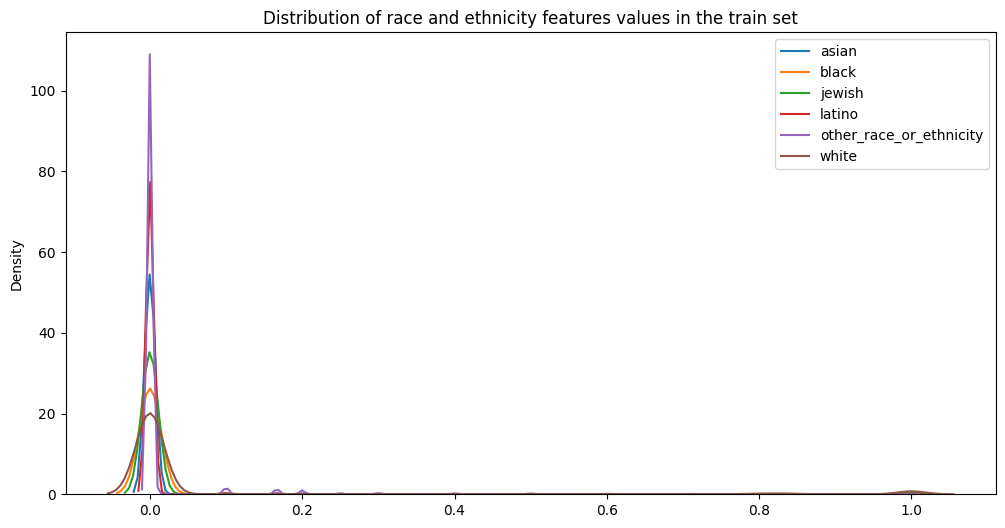

In [21]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

**We see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.**

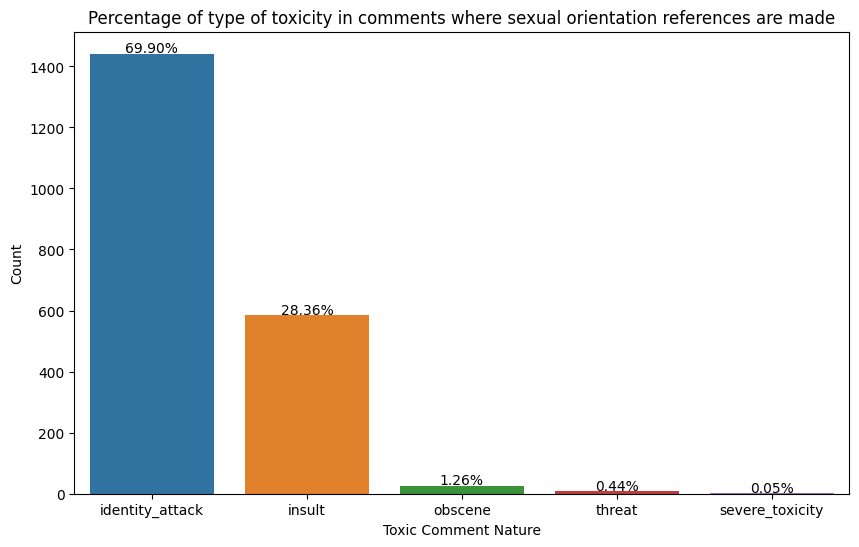

In [72]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the get_comment_nature function
def get_comment_nature(row):
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    maxarg = np.argmax(np.array(row))
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

# Get nature of each toxic comment
x = temp.apply(get_comment_nature, axis=1)

# Count the occurrences of each nature
nature_counts = x.value_counts()

# Plot the count plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=nature_counts.index, y=nature_counts.values)
plt.title('Percentage of type of toxicity in comments where sexual orientation references are made')
plt.xlabel('Toxic Comment Nature')
plt.ylabel('Count')

# Get the height and calculate the percentage, then display it in the plot itself.
total = float(len(x))
for idx, value in enumerate(nature_counts):
    # Plot at appropriate position.
    plt.text(idx, value + 3, '{:1.2f}%'.format(100 * value / total), ha='center')

plt.show()


**We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.**

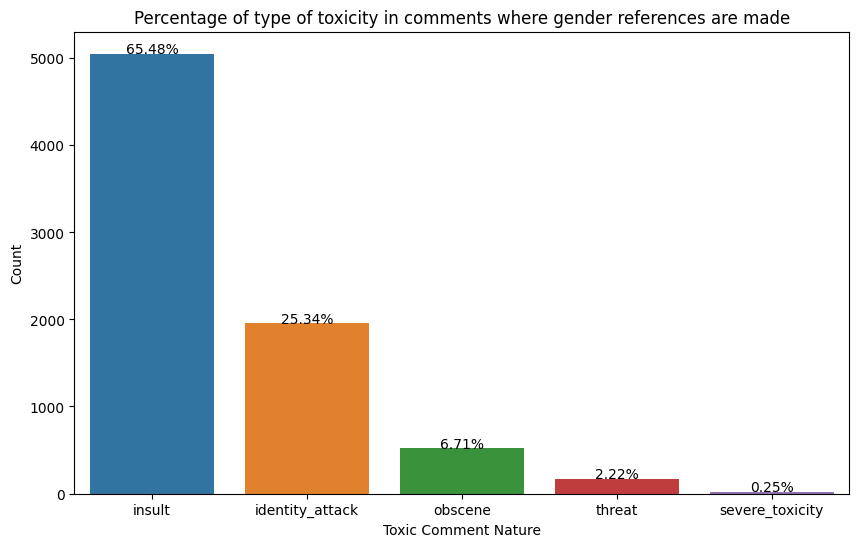

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the get_comment_nature function
def get_comment_nature(row):
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    maxarg = np.argmax(np.array(row))
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

# Get data where gender references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5)
temp = train_df[cond] # Get data where gender references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

# Get nature of each toxic comment
x = temp.apply(get_comment_nature, axis=1)

# Count the occurrences of each nature
nature_counts = x.value_counts()

# Plot the count plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=nature_counts.index, y=nature_counts.values)
plt.title('Percentage of type of toxicity in comments where gender references are made')
plt.xlabel('Toxic Comment Nature')
plt.ylabel('Count')

# Get the height and calculate the percentage, then display it in the plot itself.
total = float(len(x))
for idx, value in enumerate(nature_counts):
    # Plot at appropriate position.
    plt.text(idx, value + 3, '{:1.2f}%'.format(100 * value / total), ha='center')

plt.show()


**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

### 4. Features generated by users feedback:

- funny
- sad
- wow
- likes
- disagree

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_count(x_column, title, data, top_n=5):
    # Count the occurrences of each category in the specified column
    counts = data[x_column].value_counts().nlargest(top_n)

    # Plot the count plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(title)
    plt.xlabel(x_column)
    plt.ylabel('Count')

    # Get the height and calculate the percentage, then display it in the plot itself.
    total = float(len(data))
    for idx, value in enumerate(counts):
        # Plot at appropriate position.
        plt.text(idx, value + 3, '{:1.2f}%'.format(100 * value / total), ha='center')

    plt.show()


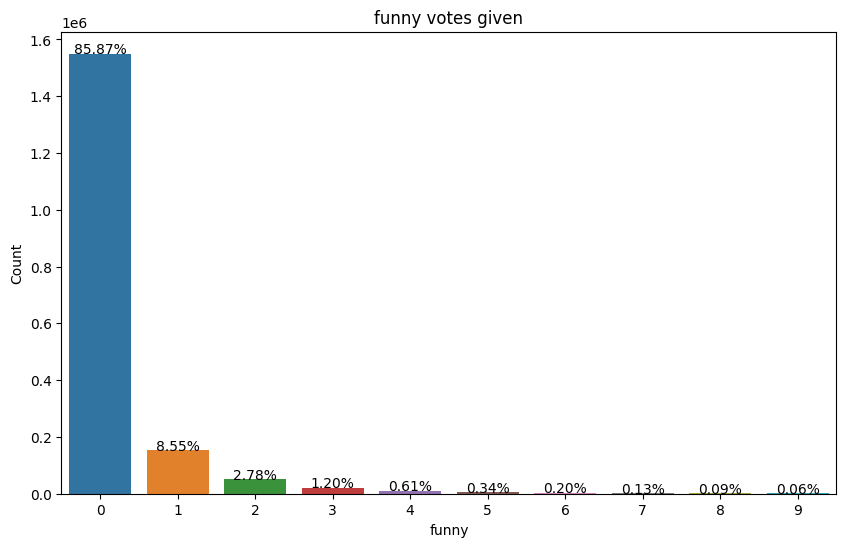

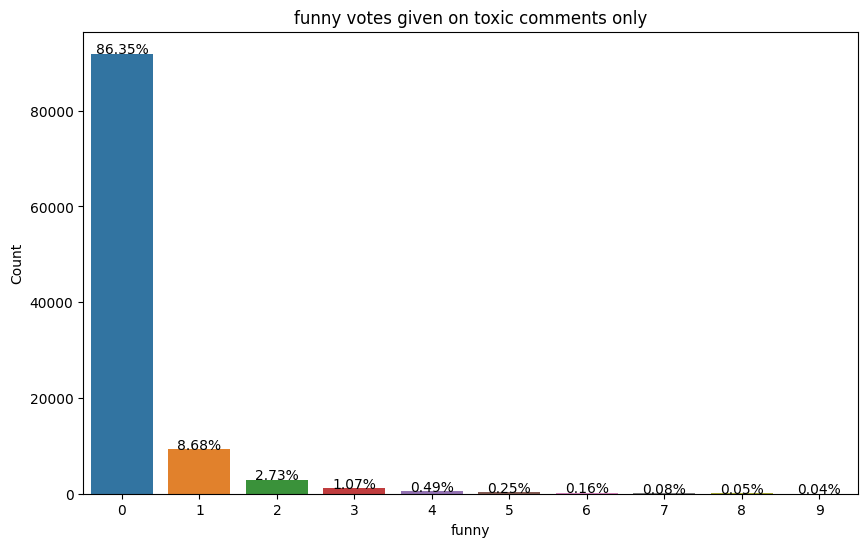

In [26]:
plot_count('funny','funny votes given', train_df, 10)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 10)

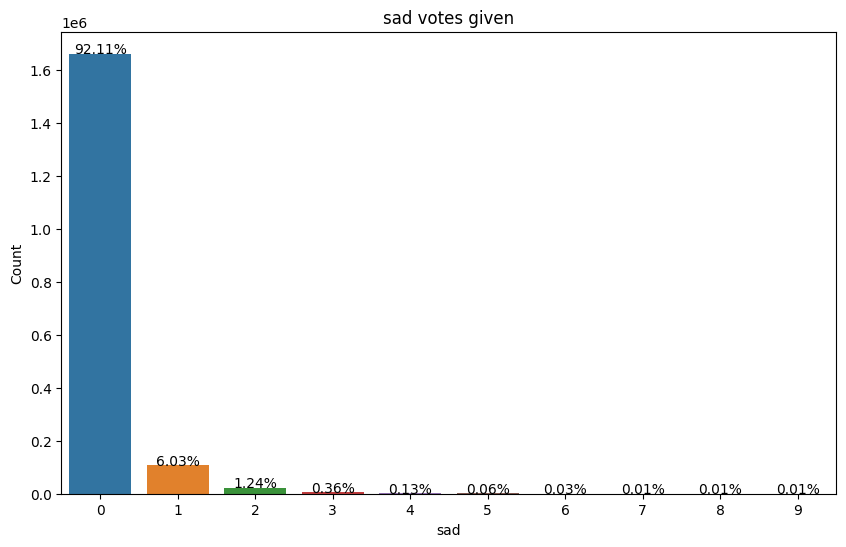

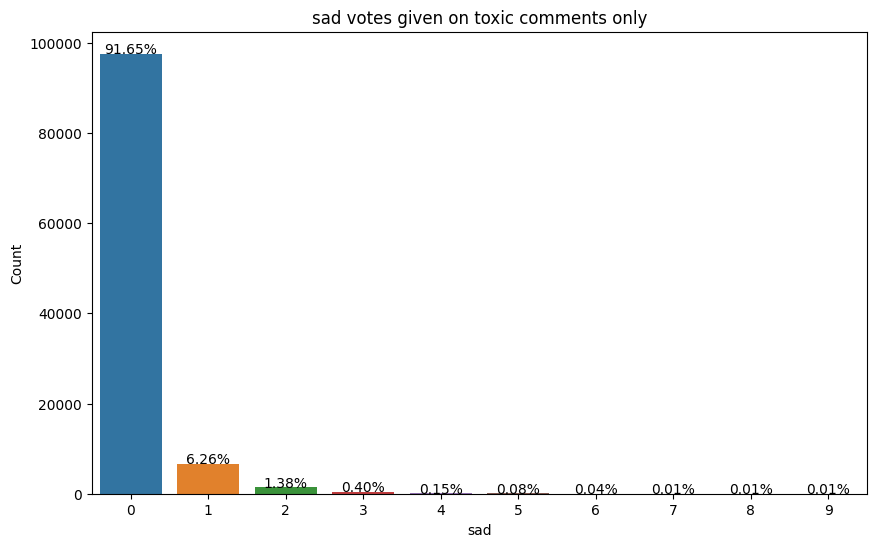

In [27]:
plot_count('sad','sad votes given', train_df, 10)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 10)

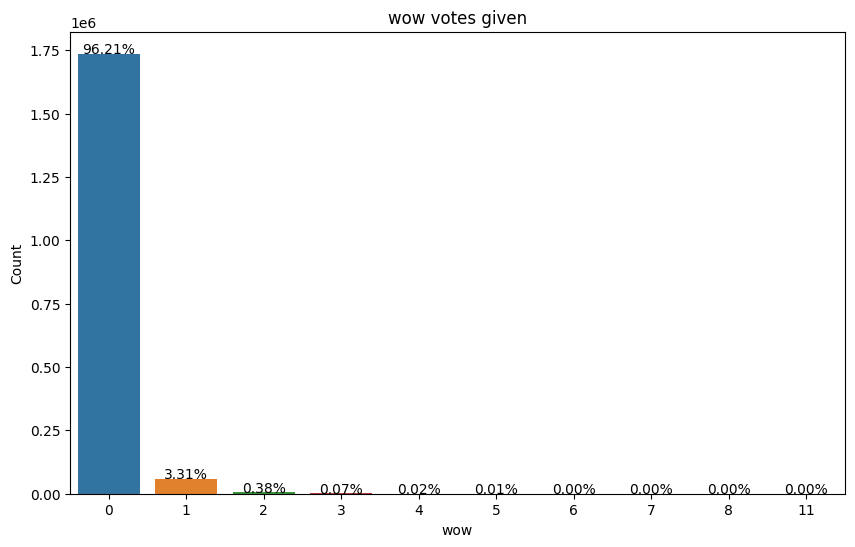

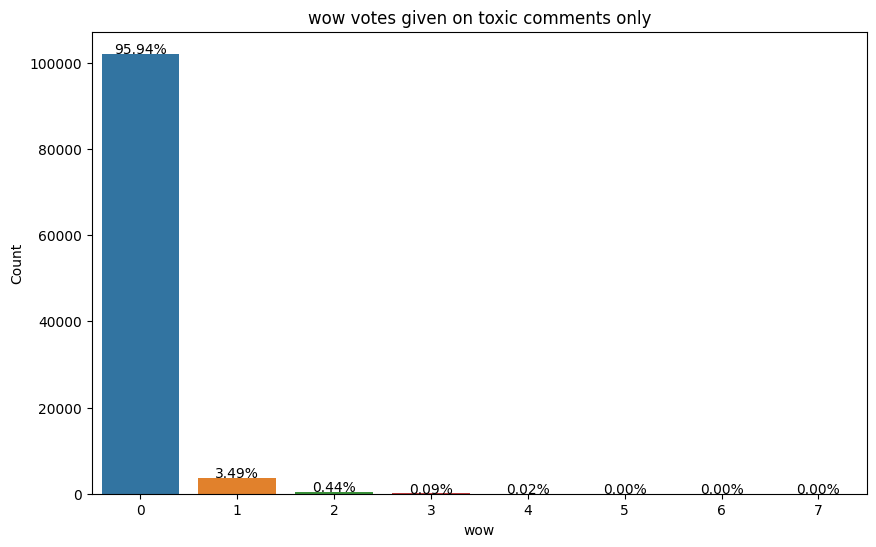

In [28]:
plot_count('wow','wow votes given', train_df, 10)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 10)

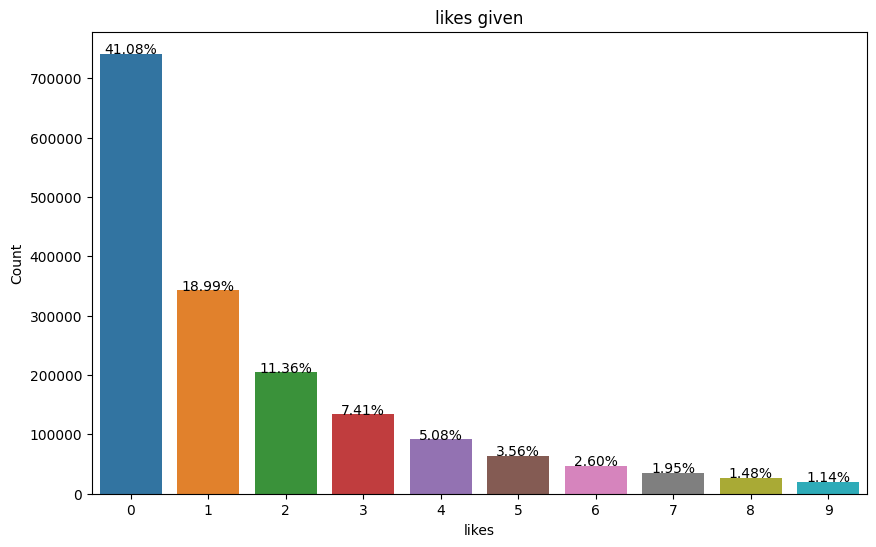

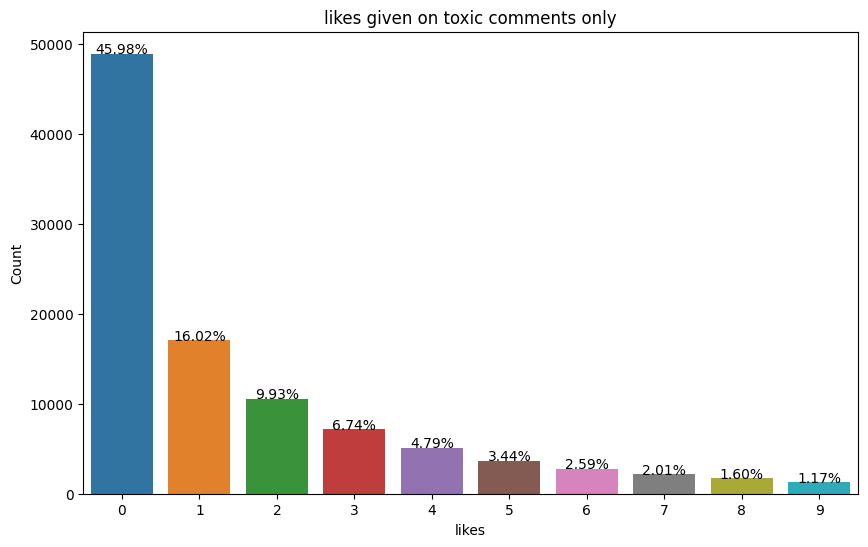

In [29]:
plot_count('likes','likes given', train_df, 10)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5], 10)

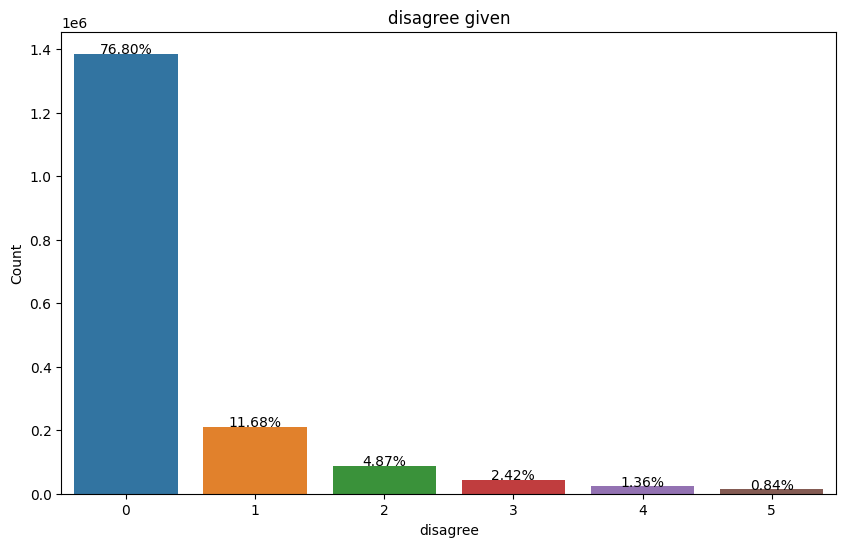

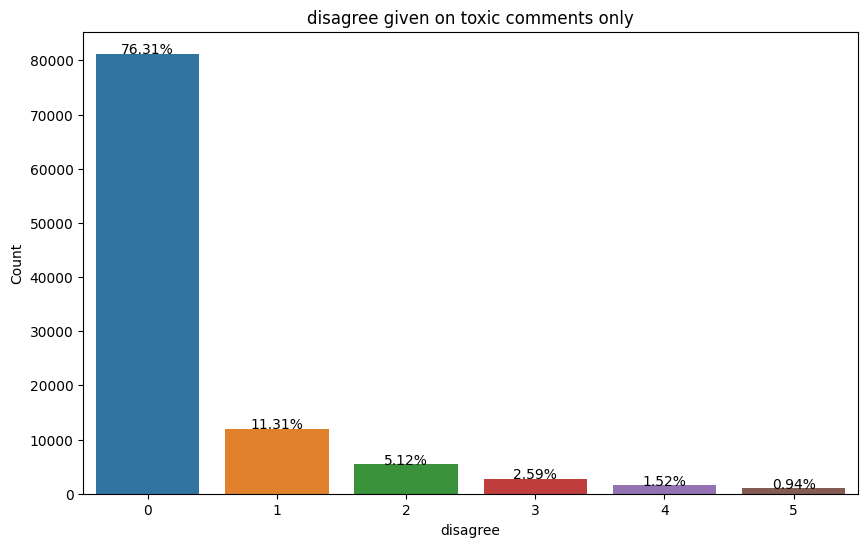

In [30]:
plot_count('disagree','disagree given', train_df, 6)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 6)

### 5. Comments_text Feature:

In [32]:
# Code From: https://www.kaggle.com/gpreda/jigsaw-eda
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40,
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

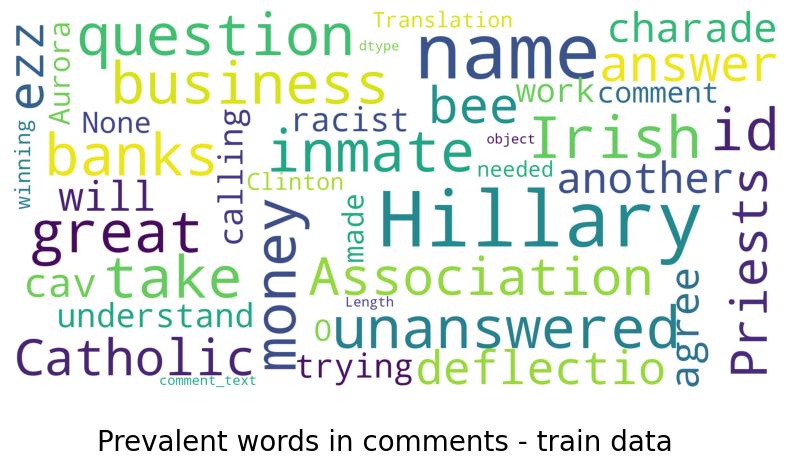

In [33]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

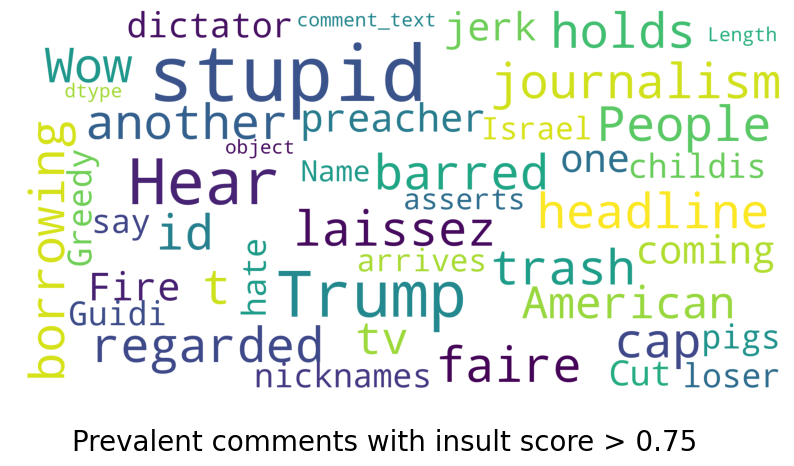

In [34]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000),
               title = 'Prevalent comments with insult score > 0.75')

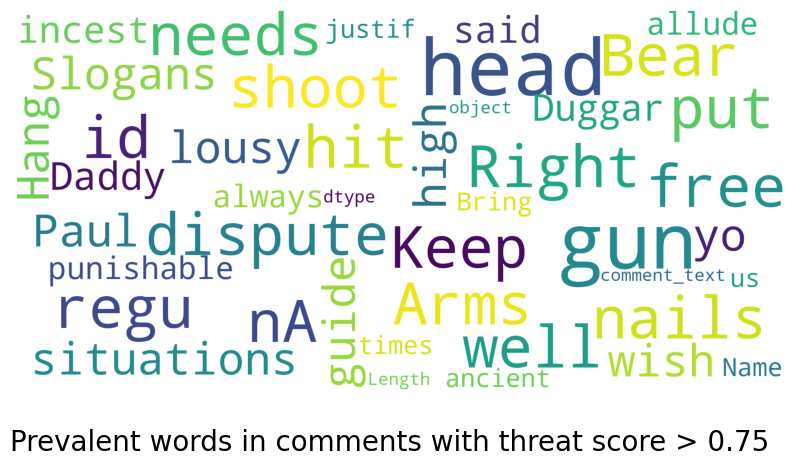

In [35]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'],
               title = 'Prevalent words in comments with threat score > 0.75')

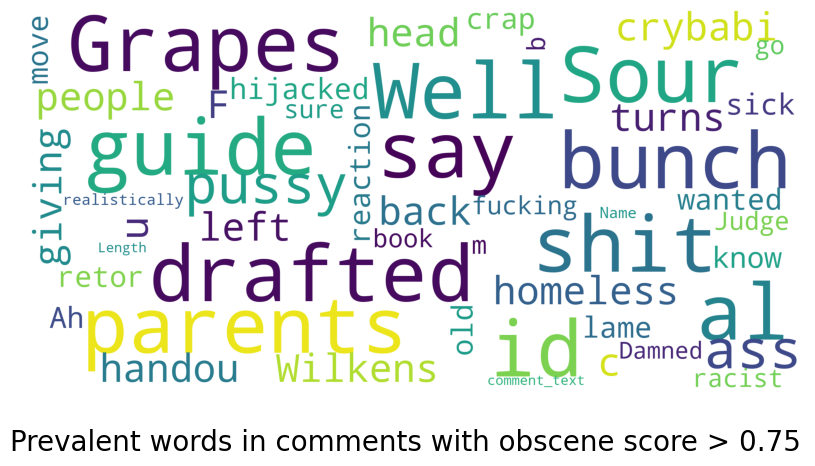

In [36]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'],
               title = 'Prevalent words in comments with obscene score > 0.75')

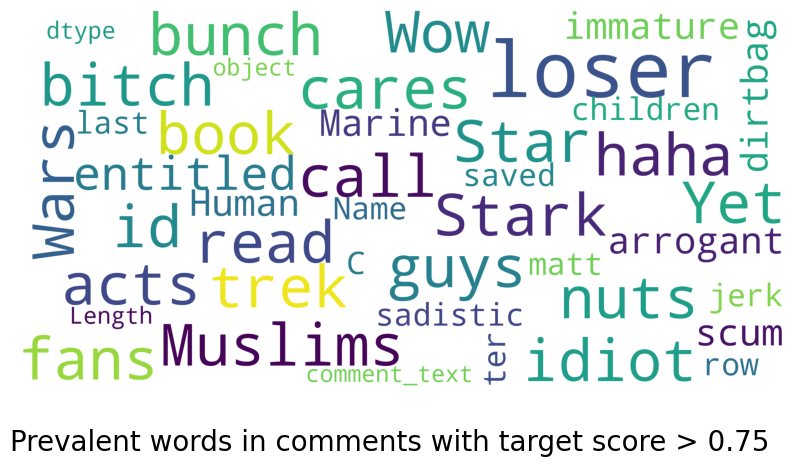

In [37]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'],
               title = 'Prevalent words in comments with target score > 0.75')

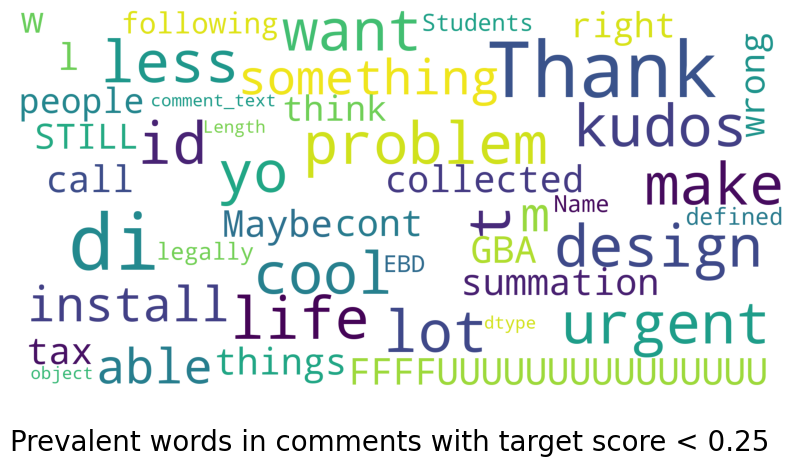

In [38]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'],
               title = 'Prevalent words in comments with target score < 0.25')

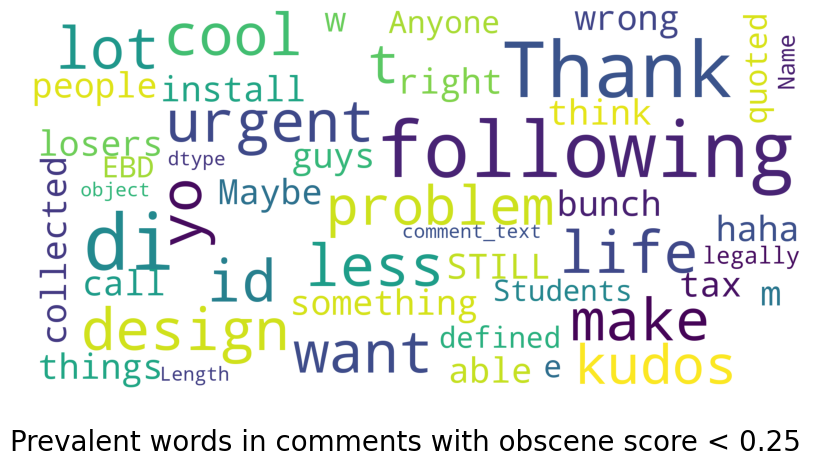

In [39]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'],
               title = 'Prevalent words in comments with obscene score < 0.25')

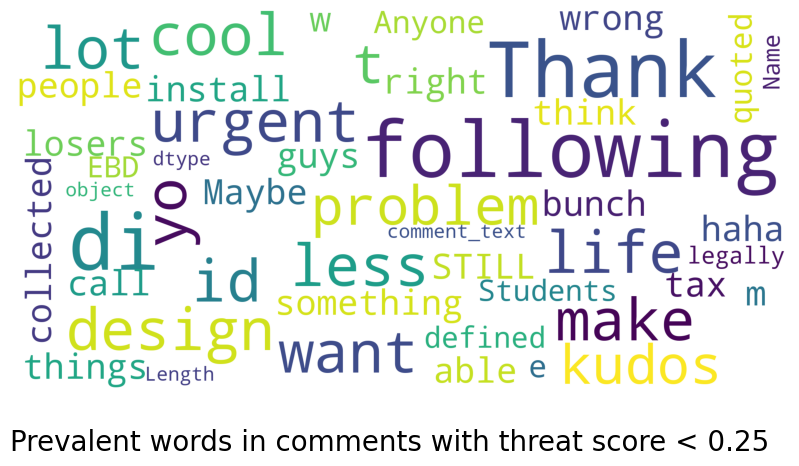

In [40]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'],
               title = 'Prevalent words in comments with threat score < 0.25')

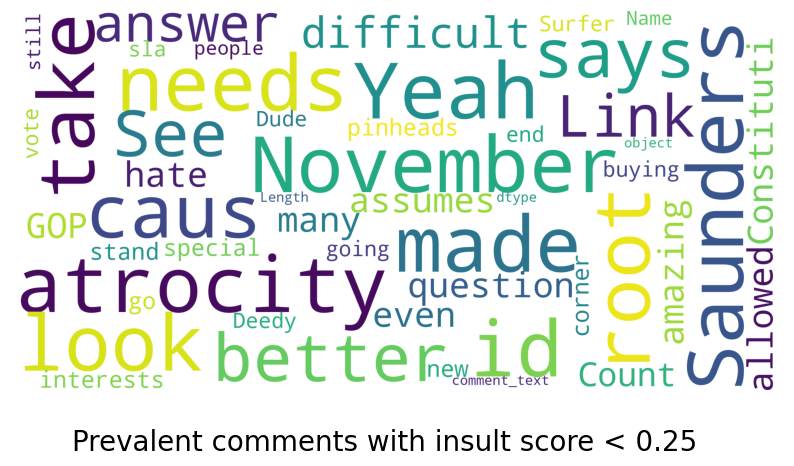

In [41]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000),
               title = 'Prevalent comments with insult score < 0.25')

## Preprocessing Text and Train-Test Split:

In [42]:
import nltk
nltk.download('stopwords')
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations

    x = text_string.split()
    new_text = []

    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))

    text_string = ' '.join(new_text)
    return text_string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [43]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

CPU times: user 14min 17s, sys: 2.85 s, total: 14min 20s
Wall time: 14min 55s


In [44]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


In [45]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: user 44.5 s, sys: 147 ms, total: 44.7 s
Wall time: 45.3 s


In [46]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [47]:
X_train.head()

,preprocessed_text
id,
5025667,reason tax polici keep chang oil industri push...
591928,christian centuri magazin god lip ear assum co...
5151341,anoth famili valu conserv bite dust
6283553,sarcast appear comment critic regim link profl...
733236,jesus call male apostl fact sir apostl ordain ...


In [48]:
X_cv.head()

,preprocessed_text
id,
5089490,accord u n 65 million peopl worldwid forcibl d...
5530497,think mean passeng pigeon carrier pigeon aliv ...
5551101,kyle quit act like hyster child
5924424,thank share inform us realli help book flight ...
6045135,neither fulli understand protest behind


In [49]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


In [50]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

## Training Models:

In [51]:
# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

### 1. Bag of Words (BoW):

In [52]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### 1.1 SGDRegressor:

##### 1.1.1 Hyperparameter Tuning:

In [53]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")

        model = SGDRegressor(alpha=a, penalty=p)
        model.fit(bow_train, y_train) # Train

        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

1e-05 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  1.9458308741996164
Mean Squared Error on cv set:  0.8344567080097214
**************************************************
1e-05 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  1.186755898366764
Mean Squared Error on cv set:  0.10503363430065124
**************************************************
0.0001 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.024494283176704247
Mean Squared Error on cv set:  0.02445000812128798
**************************************************
0.0001 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.131741325059773
Mean Squared Error on cv set:  0.030274626537896823
**************************************************
0.001 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.0314704549086152
Mean Squared Error on cv set:  0.03138441575421163
**************************************************
0.001 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.07273375877460361
Mean Squared Error on cv set:  0.02686149730624552
**************************************************
0.01 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.038888261823973355
Mean Squared Error on cv set:  0.038690569567654966
**************************************************
0.01 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.027937490620220735
Mean Squared Error on cv set:  0.02789516339230072
**************************************************
0.1 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.0388882744495898
Mean Squared Error on cv set:  0.03869066083174896
**************************************************
0.1 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03485346227567693
Mean Squared Error on cv set:  0.034690586463389406
**************************************************
1 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03888827650761415
Mean Squared Error on cv set:  0.038690484105381596
**************************************************
1 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03814678869186002
Mean Squared Error on cv set:  0.037953582754030386
**************************************************
10 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03888826254564363
Mean Squared Error on cv set:  0.03869058467653944
**************************************************
10 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03880111646774932
Mean Squared Error on cv set:  0.038604477784017446
**************************************************
100 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03888826509064708
Mean Squared Error on cv set:  0.03869052120259361
**************************************************
100 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03887845899339696
Mean Squared Error on cv set:  0.038680776027589965
**************************************************


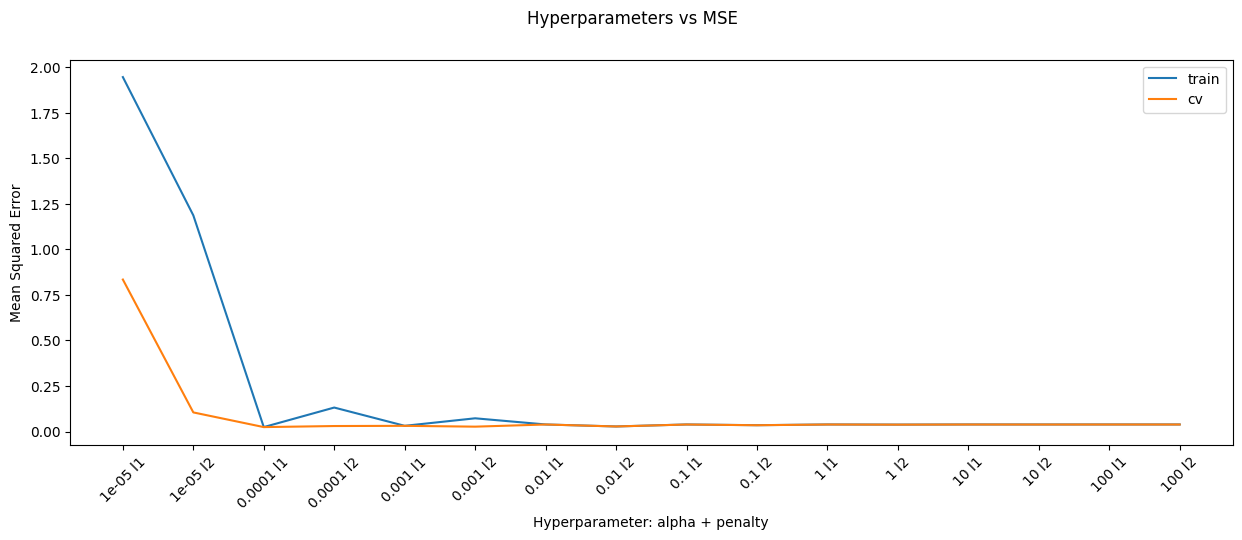

In [54]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [55]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### 1.1.2 Feature Importance:

In [56]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
top_20_features = df.sort_values("weights", ascending=False).iloc[0:20, :]
print(top_20_features)


           weights
idiot     0.426740
stupid    0.354199
moron     0.303106
pathet    0.291878
crap      0.267548
hypocrit  0.263075
dumb      0.257962
ass       0.241961
clown     0.227302
fool      0.212064
damn      0.210387
loser     0.207078
scum      0.198970
jerk      0.189872
silli     0.188030
liar      0.183355
ridicul   0.179932
shit      0.173430
buffoon   0.166063
garbag    0.164261


In [57]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.015595
agre,-0.011027
white hous,-0.010621
https,-0.010161
point,-0.009903
http,-0.009624
great,-0.009319
com,-0.009148
articl,-0.008936
interest,-0.008858


#### 1.2 Decision Trees:

##### 1.2.1 Hyperparameter Tuning:

In [58]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")

        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train

        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.0331268519443226
Mean Squared Error on cv set:  0.0330451894511672
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03312685194432259
Mean Squared Error on cv set:  0.03304518945116719
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.033129116898058635
Mean Squared Error on cv set:  0.03304656285894329
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03203634291236819
Mean Squared Error on cv set:  0.03202025233968389
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.032038911647198444
Mean Squared Error on cv set:  0.032017122628851945
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train

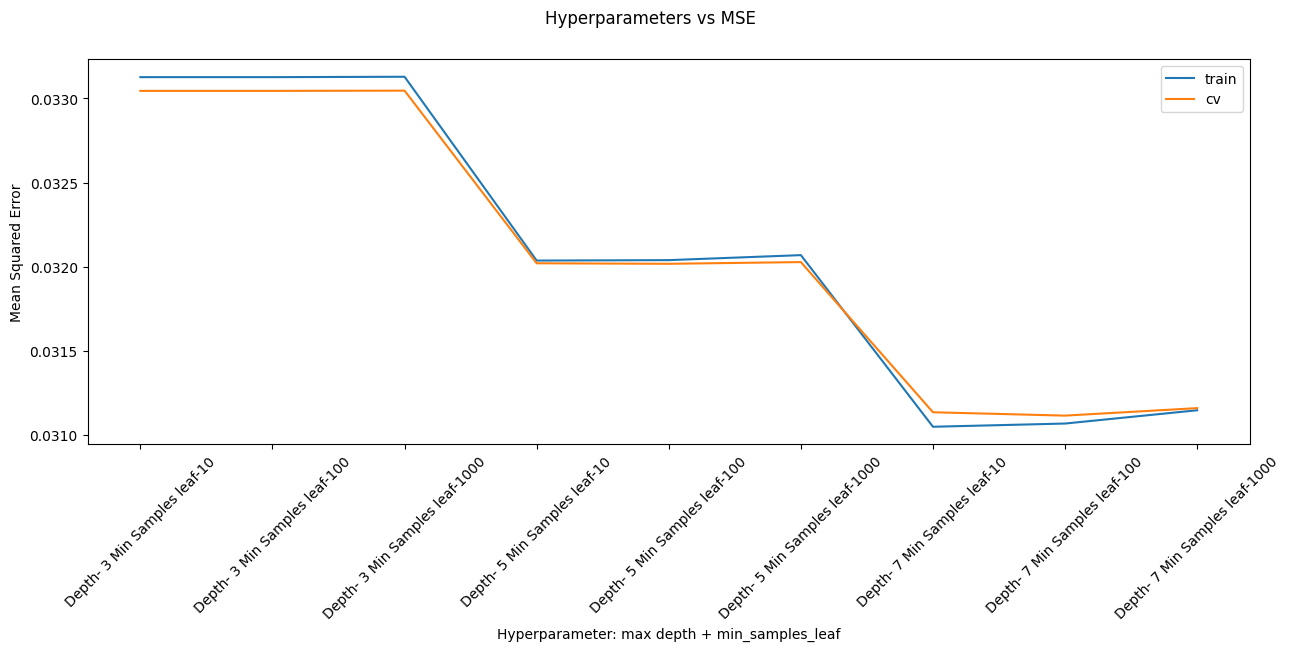

In [59]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [60]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

##### 1.2.2 Feature Importance:

In [61]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.398416
idiot,0.263066
pathet,0.069810
fool,0.068249
moron,0.063911
racist,0.059415
dumb,0.056263
one,0.004448
would,0.003908
year,0.002208


### 2. Term Frequency - Inverse Document Frequency (TFIDF) :

In [62]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### 2.1 SGDRegressor:

##### 2.1.1 Hyperparameter Tuning:

In [63]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")

        model = SGDRegressor(alpha=a, penalty=p)
        model.fit(tfidf_train, y_train) # Train

        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

1e-05 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.02527531554715406
Mean Squared Error on cv set:  0.025214011796130323
**************************************************
1e-05 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.02391190314946541
Mean Squared Error on cv set:  0.02390442272262992
**************************************************
0.0001 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.029741982670852696
Mean Squared Error on cv set:  0.029622178243654245
**************************************************
0.0001 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.025031482824157618
Mean Squared Error on cv set:  0.025003569997520642
**************************************************
0.001 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03834439947262693
Mean Squared Error on cv set:  0.03815549115771236
**************************************************
0.001 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.030085136997391126
Mean Squared Error on cv set:  0.029982145719642906
**************************************************
0.01 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.038888292671515785
Mean Squared Error on cv set:  0.03869072720877888
**************************************************
0.01 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03718944508109592
Mean Squared Error on cv set:  0.03700585051654369
**************************************************
0.1 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03888828600563711
Mean Squared Error on cv set:  0.038690705211880144
**************************************************
0.1 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.038698021670096616
Mean Squared Error on cv set:  0.0385017603755182
**************************************************
1 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.038888266626611656
Mean Squared Error on cv set:  0.038690513580315826
**************************************************
1 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03887048348320531
Mean Squared Error on cv set:  0.03867282586478909
**************************************************
10 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03888826244359392
Mean Squared Error on cv set:  0.03869054240082644
**************************************************
10 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.038886487268730216
Mean Squared Error on cv set:  0.03868874204652207
**************************************************
100 l1 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03888826905292826
Mean Squared Error on cv set:  0.03869063467885425
**************************************************
100 l2 :


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.038888063176664565
Mean Squared Error on cv set:  0.03869039867946792
**************************************************


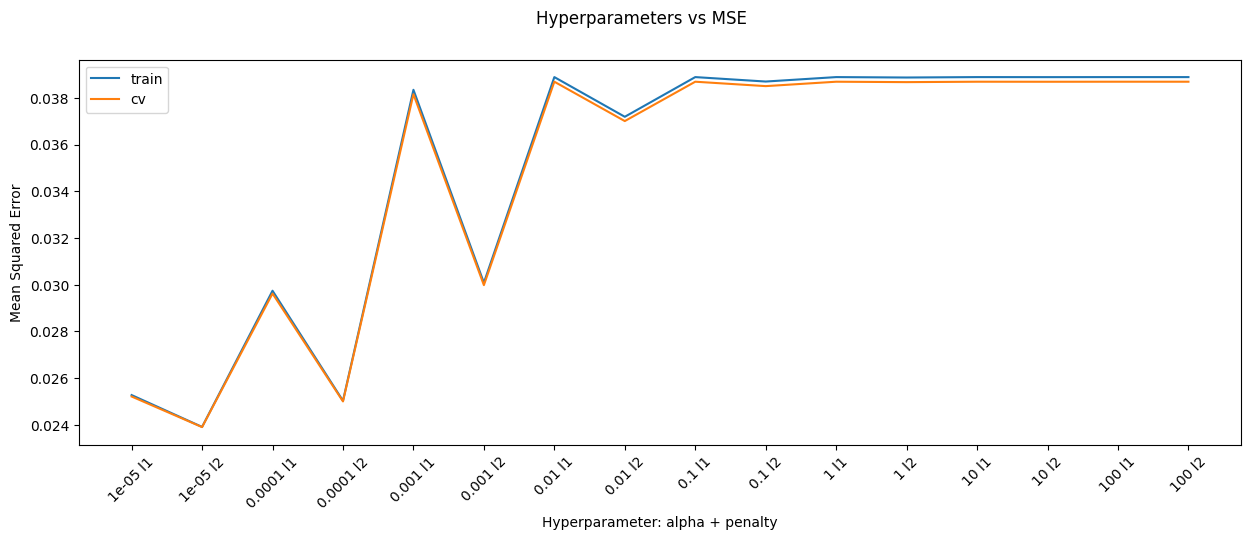

In [64]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.1.2 Feature Importance:

In [65]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
top_20_features = df.sort_values("weights", ascending=False).iloc[0:20, :]
print(top_20_features)


           weights
stupid    1.576445
idiot     1.264302
fool      0.666826
ignor     0.609313
dumb      0.598421
pathet    0.592191
moron     0.574318
loser     0.566167
ridicul   0.564445
liar      0.521307
hypocrit  0.516507
racist    0.501522
crap      0.501463
white     0.481696
troll     0.450317
damn      0.442469
kill      0.435408
clown     0.433597
silli     0.425371
black     0.425120


In [66]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.094630
interest,-0.085989
stori,-0.081361
agre,-0.078785
great,-0.073028
new,-0.070777
may,-0.070514
good,-0.069976
differ,-0.067621
point,-0.066677


#### 2.2 Decision Trees:

##### 2.2.1 Hyperparameter Tuning:

In [67]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")

        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train

        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.0329244541022356
Mean Squared Error on cv set:  0.032840628653597104
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.0329244541022356
Mean Squared Error on cv set:  0.0328406286535971
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.0329244541022356
Mean Squared Error on cv set:  0.032840628653597104
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.031767776375769295
Mean Squared Error on cv set:  0.03174352052563945
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.031768984197556804
Mean Squared Error on cv set:  0.03174575944070142
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train 

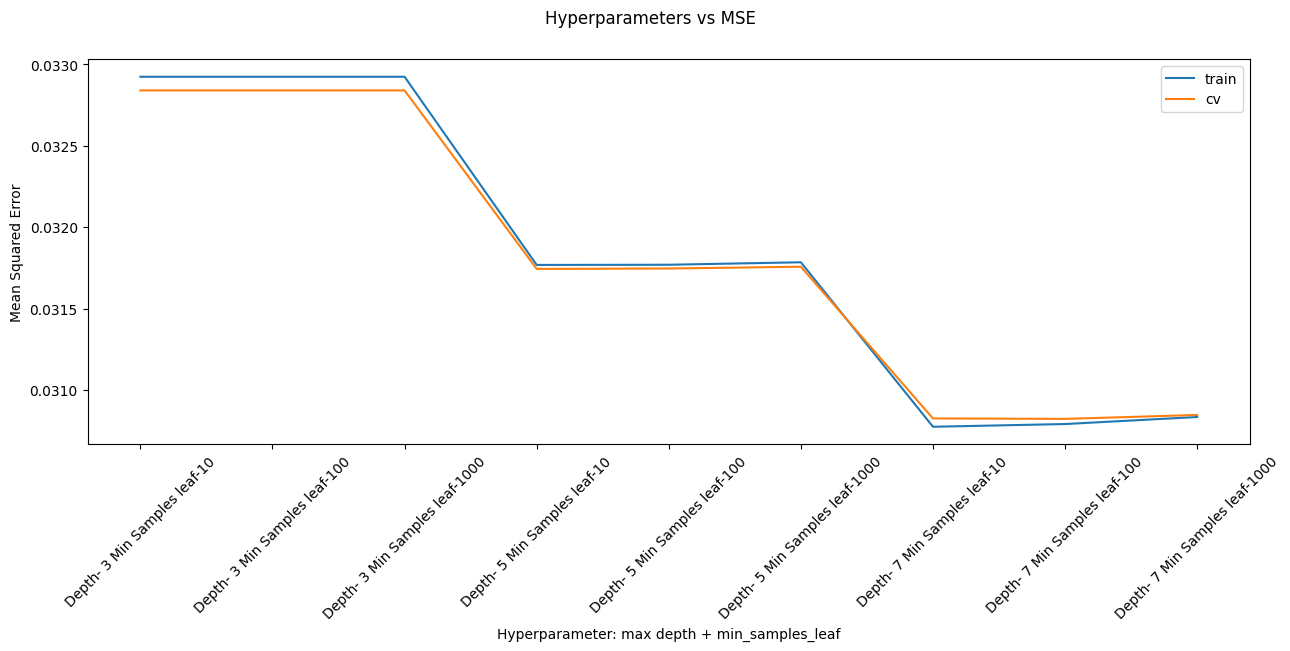

In [68]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.2.2 Feature Importance:

In [69]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.407483
idiot,0.267026
fool,0.072904
pathet,0.071888
moron,0.064440
racist,0.057565
dumb,0.054580
white,0.001836
trump,0.000770
peopl,0.000490


## Conclusions:



1. **BagOfWords:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02281
        - CV MSE Loss: 0.02326
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.0310
        - CV MSE Loss: 0.03128
2. **TFIDF:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02556
        - CV MSE Loss: 0.02584
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.03073
        - CV MSE Loss: 0.03122

In [97]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers import Embedding
import warnings
warnings.filterwarnings("ignore")

In [99]:
class LSTMFeaturization:

    def __init__(self):
        self.word_mapping = None
        self.total_words = None


    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):

        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)

        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)

        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1

        return vocab_dict



    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):

        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)

        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')

        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)

        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1

        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)

        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))

        return dictionary


    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)

    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):

        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.

            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.

        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)

        return whole

In [100]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [103]:
# !pip install keras


In [123]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming you have already preprocessed the text data and stored it in X_train, X_test, and X_cv

# Create and fit a tokenizer on the preprocessed text data in X_train
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['preprocessed_text'])

# Convert the preprocessed text data into sequences of integers using the fitted tokenizer
sequences_train = tokenizer.texts_to_sequences(X_train['preprocessed_text'])
sequences_test = tokenizer.texts_to_sequences(X_test['preprocessed_text'])
sequences_cv = tokenizer.texts_to_sequences(X_cv['preprocessed_text'])

# Pad sequences to make them of the same length
max_sequence_length = 350  # Adjust this value based on your specific task and data
lstm_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
lstm_test = pad_sequences(sequences_test, maxlen=max_sequence_length)
lstm_cv = pad_sequences(sequences_cv, maxlen=max_sequence_length)


In [124]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

(1353655, 350)
(451219, 350)
(97320, 350)


In [125]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Assuming you have already defined 'lstm_train', 'lstm_test', and 'lstm_cv'.
# You need to define 'total_words' as the total number of unique words in your dataset.

total_words = 10000  # Replace 10000 with the actual number of unique words in your dataset.

# Model architecture
embedding_vecor_length = 100
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length, input_length=350))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

# Print the model summary
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 350, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,248,961
Trainable params: 1,248,961
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 'filepath' specifies the path and filename format to save the model weights.
# The '{epoch:02d}' and '{val_loss:.2f}' are placeholders that will be filled with the epoch number and validation loss respectively.
# This will create files like 'weights-improvement-01-0.35.hdf5', 'weights-improvement-02-0.32.hdf5', and so on.
filepath = "weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"

# 'monitor' specifies the metric to monitor during training. Here, it is 'val_loss' (validation loss).
# The model weights will be saved when 'val_loss' is improved (lower for 'min' mode and higher for 'max' mode).
monitor = 'val_loss'

# 'verbose' specifies the verbosity mode. '1' means it will provide updates during saving.
verbose = 1

# 'save_best_only' is set to 'True', which means only the weights of the best model will be saved.
# If 'save_best_only' is 'False', the callback will save the model weights after each epoch, regardless of improvement.
save_best_only = True

# 'mode' specifies whether to maximize or minimize the monitored metric.
# For 'max' mode, the weights will be saved when the monitored metric increases.
# For 'min' mode, the weights will be saved when the monitored metric decreases.
mode = 'max'

# Create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=verbose, save_best_only=save_best_only, mode=mode)

# 'callbacks_list' is a list containing all the callbacks to be used during model training.
callbacks_list = [checkpoint]


In [48]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

# Example text data
X_train = ['This is a positive sentence.', 'This is a negative sentence.', 'Another positive example.']
y_train = np.array([1, 0, 1])  # Binary labels (1 for positive, 0 for negative)

X_cv = ['This is a neutral sentence.', 'Yet another positive sentence.']
y_cv = np.array([0, 1])

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text data into sequences of integers
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_cv = tokenizer.texts_to_sequences(X_cv)

# Pad sequences to make them of the same length
max_sequence_length = 10  # Set the correct sequence length based on your model's input layer
lstm_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
lstm_cv = pad_sequences(sequences_cv, maxlen=max_sequence_length)

# Get the total number of unique words in the vocabulary
total_words = len(tokenizer.word_index) + 1

# Model architecture
embedding_vecor_length = 100
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length, input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

# Define the ModelCheckpoint callback
filepath = "weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Train the model with the ModelCheckpoint callback
batch_size = 2  # Adjust batch size based on your dataset size
num_epochs = 5
# model.fit(lstm_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(lstm_cv, y_cv), verbose=1, callbacks=callbacks_list)


In [49]:
history = model.fit(lstm_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(lstm_cv, y_cv), verbose=1, callbacks=callbacks_list)

Epoch 1/5
1/2 [==============>...............] - ETA: 5s - loss: 0.2512 - mse: 0.2512
Epoch 1: val_loss improved from inf to 0.24949, saving model to weights-improvement-01-0.25.hdf5
2/2 [==============================] - 7s 2s/step - loss: 0.2586 - mse: 0.2586 - val_loss: 0.2495 - val_mse: 0.2495
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 0.2454 - mse: 0.2454
Epoch 2: val_loss improved from 0.24949 to 0.24886, saving model to weights-improvement-02-0.25.hdf5
2/2 [==============================] - 0s 141ms/step - loss: 0.2521 - mse: 0.2521 - val_loss: 0.2489 - val_mse: 0.2489
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 0.2445 - mse: 0.2445
Epoch 3: val_loss improved from 0.24886 to 0.24824, saving model to weights-improvement-03-0.25.hdf5
2/2 [==============================] - 0s 157ms/step - loss: 0.2504 - mse: 0.2504 - val_loss: 0.2482 - val_mse: 0.2482
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 0.2471 - mse: 0.2471
Epo

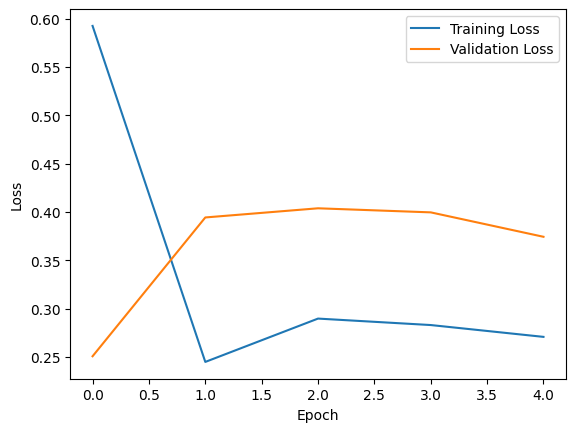

In [45]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
text_to_predict = "i will kill everyone."

# Convert the text to a sequence of integers
sequence_to_predict = tokenizer.texts_to_sequences([text_to_predict])

# Pad the sequence to make it of the same length as the training data
padded_sequence_to_predict = pad_sequences(sequence_to_predict, maxlen=max_sequence_length)

# Make the prediction
toxicity_prediction = model.predict(padded_sequence_to_predict)[0][0]

print("Toxicity prediction for the given text:", toxicity_prediction)

1/1 [==============================] - 0s 28ms/step
Toxicity prediction for the given text: 0.89764667


In [57]:
text_to_predict = "i love my friends."

# Convert the text to a sequence of integers
sequence_to_predict = tokenizer.texts_to_sequences([text_to_predict])

# Pad the sequence to make it of the same length as the training data
padded_sequence_to_predict = pad_sequences(sequence_to_predict, maxlen=max_sequence_length)

# Make the prediction
toxicity_prediction = model.predict(padded_sequence_to_predict)[0][0]

print("Toxicity prediction for the given text:", toxicity_prediction)

1/1 [==============================] - 0s 42ms/step
Toxicity prediction for the given text: 0.008162653446197488
